# UCI - Human Action Recognition - TCN

### `import` statements

In [1]:
#!pip install --upgrade keras-tcn --no-dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf  # Import TensorFlow
from time import perf_counter as tpc
from tensorflow.keras.models import Model as Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding
from tcn import TCN, tcn_full_summary
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr
from sklearn.metrics import ConfusionMatrixDisplay

### Set random generator seed

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Data directory
DATADIR = '/Users/alesandrawiecheckivergara/Desktop/PR/ICP/human+activity+recognition+using+smartphones/UCI HAR Dataset'

# Signals to load
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

activity_map = {
    0: "Walking",
    1: "Walking Upstairs",
    2: "Walking Downstairs",
    3: "Sitting",
    4: "Standing",
    5: "Laying"
}

### Utility Functions to load and process dataset

In [4]:
# Utility function to read CSV files
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Function to load signal data
def load_signals(subset):
    signals_data = []
    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(_read_csv(filename).to_numpy())
    return np.transpose(signals_data, (1, 2, 0))  # Shape: (samples, timesteps, signals)

# Function to load labels
def load_y(subset):
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return pd.get_dummies(y).to_numpy()  # One-hot encoded labels

# Function to load the entire dataset
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    return X_train, X_test, y_train, y_test

### Load the dataset

In [5]:
# Load the dataset
X_train, X_test, Y_train, Y_test = load_data()

# Print dataset shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# Convert one-hot labels to class indices
Y_train = np.argmax(Y_train, axis=1)
Y_test = np.argmax(Y_test, axis=1)

# Verify the shapes after conversion
print(f"Y_train shape after conversion: {Y_train.shape}")
print(f"Y_test shape after conversion: {Y_test.shape}")

X_train shape: (7352, 128, 9), Y_train shape: (7352, 6)
X_test shape: (2947, 128, 9), Y_test shape: (2947, 6)
Y_train shape after conversion: (7352,)
Y_test shape after conversion: (2947,)


### Reshape the data for TCN

In [6]:
# Reshape the data for TCN
n_steps = X_train.shape[1]  # Number of timesteps
input_dim = X_train.shape[2]  # Number of features (signals)
n_classes = len(np.unique(Y_train))  # Number of unique classes

# Print reshaped dataset shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)


## Define the TCN model

In [7]:
# Define the corrected TCN model
def build_tcn(input_shape, num_classes):
    i = Input(shape=input_shape)
    
    # TCN Layer
    tcn_layer = TCN(nb_filters=64,
                    kernel_size=11,
                    nb_stacks=2,
                    activation='relu',
                    use_batch_norm=True,
                    dropout_rate=0.25,
                    dilations=[1, 2, 4, 8, 16, 32, 64],
                    use_skip_connections=True)
    print('Receptive field size =', tcn_layer.receptive_field)
    
    x = tcn_layer(i)
    
    # Dense Output Layer
    x = Dense(num_classes, activation='softmax')(x)
    
    # Build Model
    model = Model(inputs=[i], outputs=[x])
    return model


# Build the TCN model
input_shape = (n_steps, input_dim)  # Update the input shape
model = build_tcn(input_shape=input_shape, num_classes=n_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Receptive field size = 5081


## Model Summary

In [8]:
model.summary()
#tcn_full_summary(model, expand_residual_blocks=False)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn (TCN)                       │ (None, 64)             │     1,232,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,232,838 (4.70 MB)

 Trainable params: 1,229,254 (4.69 MB)

 Non-trainable params: 3,584 (14.00 KB)

### Trainning Model

In [9]:
# Define the CNN model
epochs = 500
batch_size = 64
patience = 10

tic = tpc() # Start time...

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, Y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
)
toc = tpc() # End time...

!say "TCN model fitting completed"

myTime = toc - tic
myTimeMins = myTime // 60
myTimeSecs = myTime % 60
timingStr = "TCN Model took {Mins:.0f} minutes and {Secs:=.2f} seconds to fit!".format(Mins=myTimeMins,Secs=myTimeSecs)
print(timingStr)
!say {timingStr}

Epoch 1/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 374ms/step - accuracy: 0.5554 - loss: 2.8329 - val_accuracy: 0.7027 - val_loss: 0.6710
Epoch 2/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 384ms/step - accuracy: 0.7650 - loss: 0.6075 - val_accuracy: 0.7591 - val_loss: 0.5859
Epoch 3/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 397ms/step - accuracy: 0.8485 - loss: 0.3946 - val_accuracy: 0.8168 - val_loss: 0.4760
Epoch 4/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 404ms/step - accuracy: 0.9018 - loss: 0.2726 - val_accuracy: 0.8985 - val_loss: 0.2385
Epoch 5/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 407ms/step - accuracy: 0.9061 - loss: 0.2410 - val_accuracy: 0.9019 - val_loss: 0.2584
Epoch 6/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 398ms/step - accuracy: 0.9273 - loss: 0.1903 - val_accuracy: 0.9175 - val_loss: 0.2118
Epoch 7/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 408ms/step - accuracy: 0.9243 - loss: 0.1877 - val_accuracy: 0.9141 - val_loss: 0.2136
Epoch 8/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 398ms/step - accuracy: 0.9317 -

### Plot training history

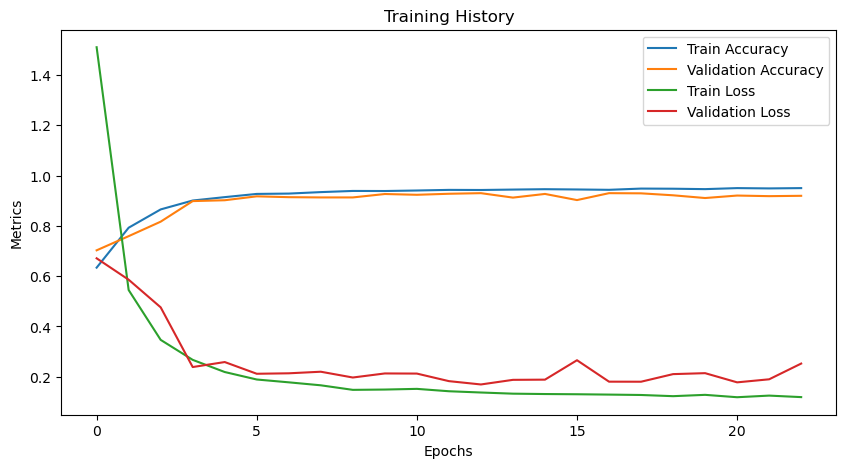

In [10]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.title('Training History')
    plt.show()
    
# Plot results
plot_training_history(history)

### Evaluate the model

In [11]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=64)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.8943 - loss: 0.2381
Test Accuracy: 93.01%


### Confusion Matrix

93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step


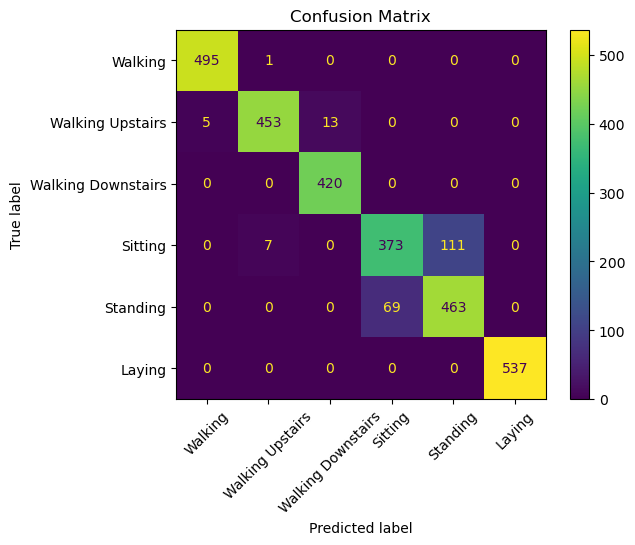

In [12]:
# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = cm(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(activity_map.values()))
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

### Classification Report

In [13]:
print(cr(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       496
           1       0.98      0.96      0.97       471
           2       0.97      1.00      0.98       420
           3       0.84      0.76      0.80       491
           4       0.81      0.87      0.84       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

